In [11]:
import numpy as np


from watermatrices import Amat, Bmat, yvec

# Create the data dictionary

size = Amat.shape[0]

E = np.block([[Amat, Bmat],
              [Bmat, Amat]])

S = np.block([[np.eye(size),           np.zeros((size,size))], 
              [np.zeros((size,size)), -np.eye(size)]])

z = np.hstack([yvec,-yvec])


data = {"E" : E, "S" : S, "z" : z}

In [10]:
ws = [0.800, 1.146, 1.400]

from solutions import condition_number

for w in ws:
    print("ω = ", w)
    print("Condition number of E - ωS: ", condition_number(E-w*S))

ω =  0.8
Condition number of E - ωS:  327.81670424209915
ω =  1.146
Condition number of E - ωS:  152679.2687523386
ω =  1.4
Condition number of E - ωS:  227.19443667104446


In [12]:
dw = 1e-3


from solutions import sigfigs
for w in ws:
    print(sigfigs(w, dw))

2.9030899869919438
3.059184617631371
3.146128035678238


In [13]:
dw = 1e-3

from solutions import b_bound
for w in ws:
    bound = b_bound(w, dw)
    print("ω = ", w)
    print(f"Bound {bound:.4}")
    print(f"Number of significant figures: {sigfigs(w, bound):f}")

ω =  0.8
Bound 0.01044
Number of significant figures: 1.884328
ω =  1.146
Bound 4.81
Number of significant figures: -0.622967
ω =  1.4
Bound 0.007101
Number of significant figures: 2.294820


# LU Decomp

In [15]:
from solutions import lu_factorize

M = np.array([2, 1, 1, 4, 1, 4, -6, -5, 3], dtype=float)
M = M.reshape((3,3))
z = [4, 11, 4]

print("M")
print(M, end= "\n\n")
    
d = lu_factorize(M, should_pivot=False)
print(*d,sep="\n")


M
[[ 2.  1.  1.]
 [ 4.  1.  4.]
 [-6. -5.  3.]]

[[ 2.  1.  1.]
 [ 0. -1.  2.]
 [ 0.  0.  2.]]
[[ 1.  0.  0.]
 [ 2.  1.  0.]
 [-3.  2.  1.]]


In [16]:
from solutions import solve

# M = np.array([2, 1, 1, 4, 1, 4, -6, -5, 3], dtype=float)
M = np.array([2, 1, 1, 4, 1, 4, -6, -5, 3], dtype=float)

M = M.reshape((3,3))
z = [4, 11, 4]


solve(M,z)


array([-4,  7,  5])

In [17]:
from solutions import solve_alpha

ws = [0.800, 1.146, 1.400]
dw = 0.5e-3
# ws = [0.246]
# dw = 0



for w in ws:
    for d in [-dw, dw]:
        sol = solve_alpha(w + d)
        
        print( w,("+" if d > 0 else "") + str(d))
        print(sol)
        bound = b_bound(w, dw)
        print("bound", bound)


0.8 -0.0005
1.6278156988765353
bound 0.005220745069573262
0.8 +0.0005
1.6444312026849457
bound 0.005220745069573262
1.146 -0.0005
994.752991630176
bound 2.4050352674535698
1.146 +0.0005
-4185.018283381866
bound 2.4050352674535698
1.4 -0.0005
-2.7138801135166397
bound 0.0035504027789308675
1.4 +0.0005
-2.699926805997851
bound 0.0035504027789308675


In [18]:
import matplotlib.pyplot as plt


C:\Users\jakob\AppData\Local\Temp\ipykernel_9808\3915683293.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


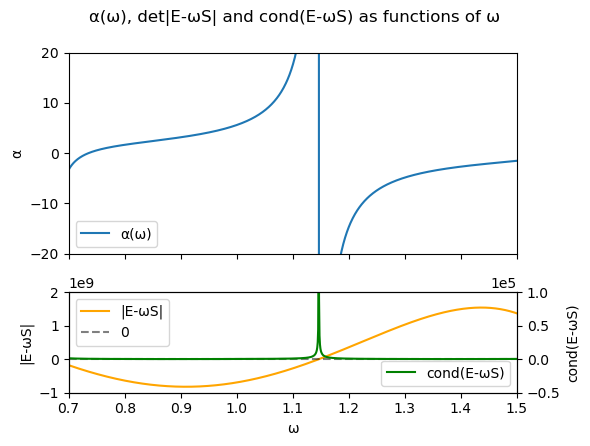

In [19]:
w_table = np.linspace(0.7, 1.5, 1000, endpoint=True)

alpha_table = np.array([solve_alpha(w) for w in w_table])



# plt.vlines(w_interesting, -1e3, 1e3,"red", '--')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,4.5), gridspec_kw={'height_ratios': [2, 1]}, constrained_layout=True)
axs[0].plot(w_table, alpha_table, label = "α(ω)")
axs[1].plot(w_table, [np.linalg.det(data["E"]-w*data["S"]) for w in w_table], label = "|E-ωS|", color="orange")
axs[0].set_ylim(-20,20)
axs[1].set_ylim(-1e9,2e9)
plt.xlim(0.7,1.5)
axs[1].hlines(0, 0.7, 1.5, "black", '--', alpha=0.5, label = "0")
axs[0].set_ylabel("α")
axs[1].set_ylabel("|E-ωS|")
axs[1].set_xlabel("ω")
fig.suptitle("α(ω), det|E-ωS| and cond(E-ωS) as functions of ω")

# seperate y axis
axs2 = axs[1].twinx()
axs2.set_ylim(-50000,1e5)
axs2.set_ylabel("cond(E-ωS)")

# use scientific notation for y axis
axs2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

axs2.plot(w_table,[condition_number(data["E"]-w*data["S"]) for w in w_table], label = "cond(E-ωS)", color="green")

axs[0].legend(loc="lower left")
axs[1].legend(loc="upper left")
axs2.legend(loc="lower right")


plt.tight_layout()
plt.show()

householder

In [20]:
from solutions import householder_QR_slow, same

# B = np.array([[2,-2,18],[2,1,0],[1,2,0]]).astype(float)
example_31 = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,1,0],[-1,0,1],[0,-1, 1]]).astype(float)

Q, R = householder_QR_slow(example_31)

print("Q@R = A?")
print(same(Q@R, example_31))


Q@R = A?
True


In [21]:
from solutions import householder_fast 

VR = householder_fast(example_31)

print(VR, end="\n\n")


[[-1.73205081e+00  5.77350269e-01  5.77350269e-01]
 [ 2.73205081e+00 -1.63299316e+00  8.16496581e-01]
 [-6.79869978e-17  2.63299316e+00 -1.41421356e+00]
 [ 9.83286241e-17 -5.72291037e-17  2.41421356e+00]
 [-1.00000000e+00  7.88675135e-01  3.32449118e-02]
 [-1.00000000e+00 -2.11324865e-01  7.23142860e-01]
 [ 0.00000000e+00 -1.00000000e+00  6.89897949e-01]]



In [22]:
from solutions import solve_least_squares

example_31 = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,1,0],[-1,0,1],[0,-1,1]]).astype(float)

b_31 = np.array([1237, 1941, 2417, 711, 1177, 475]).astype(float)
x_31 = [1236, 1943, 2416]

sol = solve_least_squares(example_31, b_31)

print(sol, "\nIs right?:", same(sol, x_31))


[1236. 1943. 2416.] 
Is right?: True


In [23]:
from HHexamples import A1, b1, x1

sol = solve_least_squares(A1, b1.astype(float), print_upper=True)

print("Correct?",same(sol, x1))

print(f"{sol[0]:.3f} and {sol[1]:.3f}")

R1
[[-5.91607978 -7.43735744]
 [ 0.          0.82807867]]
Correct? True
-0.000 and 0.500


Polyfit

Vandermonde matrix

In [24]:
import numpy as np
import matplotlib.pyplot as plt

The coefficients for N = 4:
[ -29.20165559   57.68267638   60.35951443 -177.7027119    94.21099494]


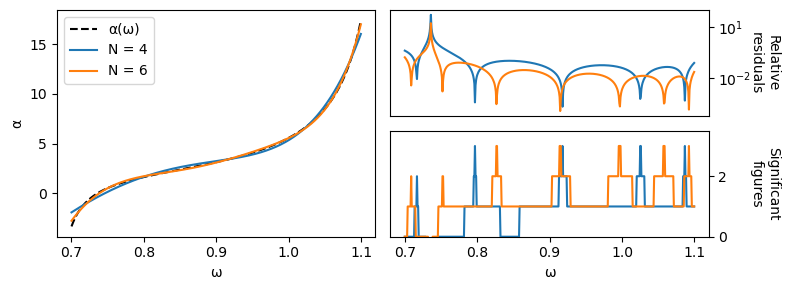

In [25]:
from solutions import solve_polynomial_1, solve_alpha, sigfigs
w_table = np.linspace(0.7, 1.5, 1000, endpoint=True)

alpha_table = np.array([solve_alpha(w) for w in w_table])
mask = w_table < 1.1


# fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6,4.5), gridspec_kw={'height_ratios': [1,1,1]}, constrained_layout=True)
fig = plt.figure(figsize=(8, 3))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(2, 2, 2,)
ax2 = fig.add_subplot(2, 2, 4,)
# ax1.get_shared_x_axes().join(ax1, ax2)

axs = [ax0, ax1, ax2]
# make three uneven suplots, one big to the left and two small to the right

axs[0].plot(w_table[mask], alpha_table[mask], '--',label = "α(ω)", color="black")
for N in [4,6]:
    sol = solve_polynomial_1(w_table[mask], alpha_table[mask], N)
    axs[0].plot(w_table[mask], sol, label=f"N = {N}")

    residual = np.array(sol - alpha_table[mask])

    relative_residual = np.abs(residual) / np.abs(alpha_table[mask])
    
    axs[1].plot(w_table[mask], relative_residual, label=f"N = {N}")

    sigf = np.floor(sigfigs(alpha_table[mask], residual))
    axs[2].plot(w_table[mask], sigf, label=f"N = {N}")

axs[1].set_yscale("log")
axs[2].set_ylim(0, 3.5)
axs[0].legend()
axs[0].set_ylabel("α")

axs[1].set_ylabel("Relative\nresiduals", rotation=270, labelpad=20)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].set_ylabel("Significant\nfigures", rotation=270, labelpad=38)
axs[2].yaxis.set_label_position("right")
axs[2].yaxis.tick_right()

axs[1].set_xticks([])
axs[0].set_xlabel("ω")
axs[2].set_xlabel("ω")

fig.tight_layout()
plt.show()

![Alt text](image.png)

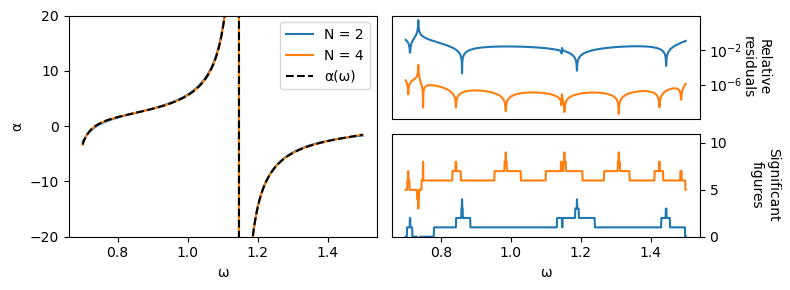

In [26]:
# x_range = np.linspace(0.7, 1.5, 1000)
# vandermonde_2 = lambda ws, N: np.array([[w**(i) for i in range(N)] + [-get_a w**(i) for i in range(N)]  for w in ws])
from solutions import solve_polynomial_2

# np.tile()

alpha_table = np.array([solve_alpha(w) for w in w_table])





# mask = w_table < w_interesting-0.2

fig = plt.figure(figsize=(8, 3))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(2, 2, 2,)
ax2 = fig.add_subplot(2, 2, 4,)
# ax1.get_shared_x_axes().join(ax1, ax2)
axs = [ax0, ax1, ax2]


for N in [2, 4]:
    sol = solve_polynomial_2(w_table, alpha_table, N)
    # final_sol = sol_a - sol_b
    residual = sol - alpha_table

    relative_residual = np.abs(residual) / np.abs(alpha_table)
    sigf = np.floor(sigfigs(alpha_table, residual))

    axs[0].plot(w_table, sol, label=f"N = {N}")
    axs[1].plot(w_table, relative_residual, label=f"N = {N}")
    axs[2].plot(w_table, sigf, label=f"N = {N}")

axs[0].plot(w_table, alpha_table, '--',label = "α(ω)", color="black")


axs[1].set_yscale("log")

axs[0].set_ylim(-20,20)
axs[2].set_ylim(0, 11)

axs[0].legend()
axs[0].set_ylabel("α")

axs[1].set_ylabel("Relative\nresiduals", rotation=270, labelpad=20)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].set_ylabel("Significant\nfigures", rotation=270, labelpad=38)
axs[2].yaxis.set_label_position("right")
axs[2].yaxis.tick_right()

axs[1].set_xticks([])
axs[0].set_xlabel("ω")
axs[2].set_xlabel("ω")

fig.tight_layout()
plt.show()

In [27]:
w_table_extended = np.linspace(-4, 4, 5000, endpoint=True)

alpha_table_extended = np.array([solve_alpha(w) for w in w_table_extended])

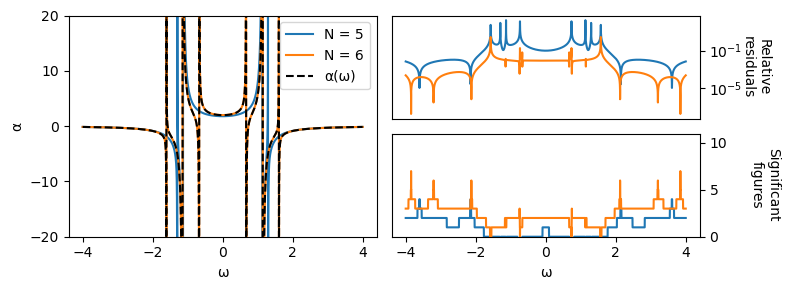

In [28]:
# x_range = np.linspace(0.7, 1.5, 1000)
# vandermonde_2 = lambda ws, N: np.array([[w**(i) for i in range(N)] + [-get_a w**(i) for i in range(N)]  for w in ws])


# mask = w_table < w_interesting-0.2

fig = plt.figure(figsize=(8, 3))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(2, 2, 2,)
ax2 = fig.add_subplot(2, 2, 4,)
# ax1.get_shared_x_axes().join(ax1, ax2)
axs = [ax0, ax1, ax2]


for N in [5, 6]:
    sol = solve_polynomial_2(w_table_extended, alpha_table_extended, N)
    residual = sol - alpha_table_extended

    relative_residual = np.abs(residual) / np.abs(alpha_table_extended)
    sigf = np.floor(sigfigs(alpha_table_extended, residual))

    axs[0].plot(w_table_extended, sol, label=f"N = {N}")
    axs[1].plot(w_table_extended, relative_residual, label=f"N = {N}")
    axs[2].plot(w_table_extended, sigf, label=f"N = {N}")

axs[0].plot(w_table_extended, alpha_table_extended, '--',label = "α(ω)", color="black")


axs[1].set_yscale("log")

axs[0].set_ylim(-20,20)
axs[2].set_ylim(0, 11)

axs[0].legend()
axs[0].set_ylabel("α")

axs[1].set_ylabel("Relative\nresiduals", rotation=270, labelpad=20)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].set_ylabel("Significant\nfigures", rotation=270, labelpad=38)
axs[2].yaxis.set_label_position("right")
axs[2].yaxis.tick_right()

axs[1].set_xticks([])
axs[0].set_xlabel("ω")
axs[2].set_xlabel("ω")

fig.tight_layout()
plt.show()